In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt #show img

## 卷積 並超過0~255 需拉回

In [2]:
# mask
# [(i-1,j-1),(i,j-1),(i+1,j-1),
#  (i-1,j),  (i,j),  (i+1,j),
#  (i-1,j+1),(i,j+1),(i+1,j+1)
# ]
def convolution(img,mask,pad):
    h,w=img.shape
    out = np.zeros(img.shape)

    # pad=1 ~ pad-w=257
    for i in  range(pad,h-pad):
        for j in range(pad,w-pad):
            out[i,j]=mask[0]*img[i-1,j-1]\
                    + mask[1]*img[i,j-1]\
                    + mask[2]*img[i+1,j-1]\
                    + mask[3]*img[i-1,j]\
                    + mask[4]*img[i,j]\
                    + mask[5]*img[i+1,j]\
                    + mask[6]*img[i-1,j+1]\
                    + mask[7]*img[i,j+1]\
                    + mask[8]*img[i+1,j+1]
            # boundary check 超過邊界拉回在邊界上
            out[i][j] = int(np.clip(out[i][j], 0, 255))
    return out

# img_diff2=convolution(img_padded,laplace_mask,pad)



## 一階微分 套 sobel 公式
f=|(z7+2z8+z9)-(z1+2z2+z3)| + |(z3+2z6+z9)-(z1+2z4+z7)|

In [3]:
# mask
# [(i-1,j-1),(i,j-1),(i+1,j-1),
#  (i-1,j),  (i,j),  (i+1,j),
#  (i-1,j+1),(i,j+1),(i+1,j+1)
# ]
def sobel(img,pad):
    h,w=img.shape
    out = np.zeros(img.shape)
    # pad=1 ~ pad-w=257
    for i in  range(pad,h-pad):
        for j in range(pad,w-pad):
            out[i,j]= np.abs((img[i-1,j+1] + 2*img[i,j+1] + img[i+1,j+1])-(img[i-1,j-1] + 2*img[i,j-1] + img[i+1,j-1]))\
                    + np.abs((img[i+1,j-1] + 2*img[i+1,j] + img[i+1,j+1])-(img[i-1,j-1] + 2*img[i-1,j] + img[i-1,j+1]))
            # boundary check 超過邊界拉回在邊界上
            out[i][j] = int(np.clip(out[i][j], 0, 255))
    return out

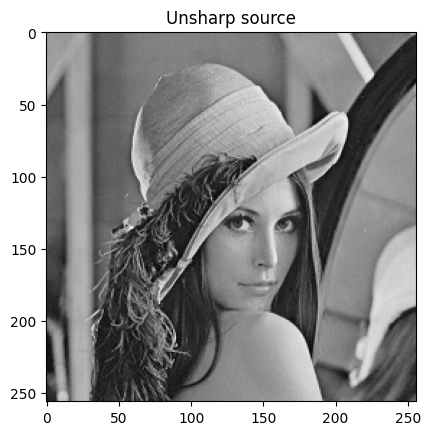

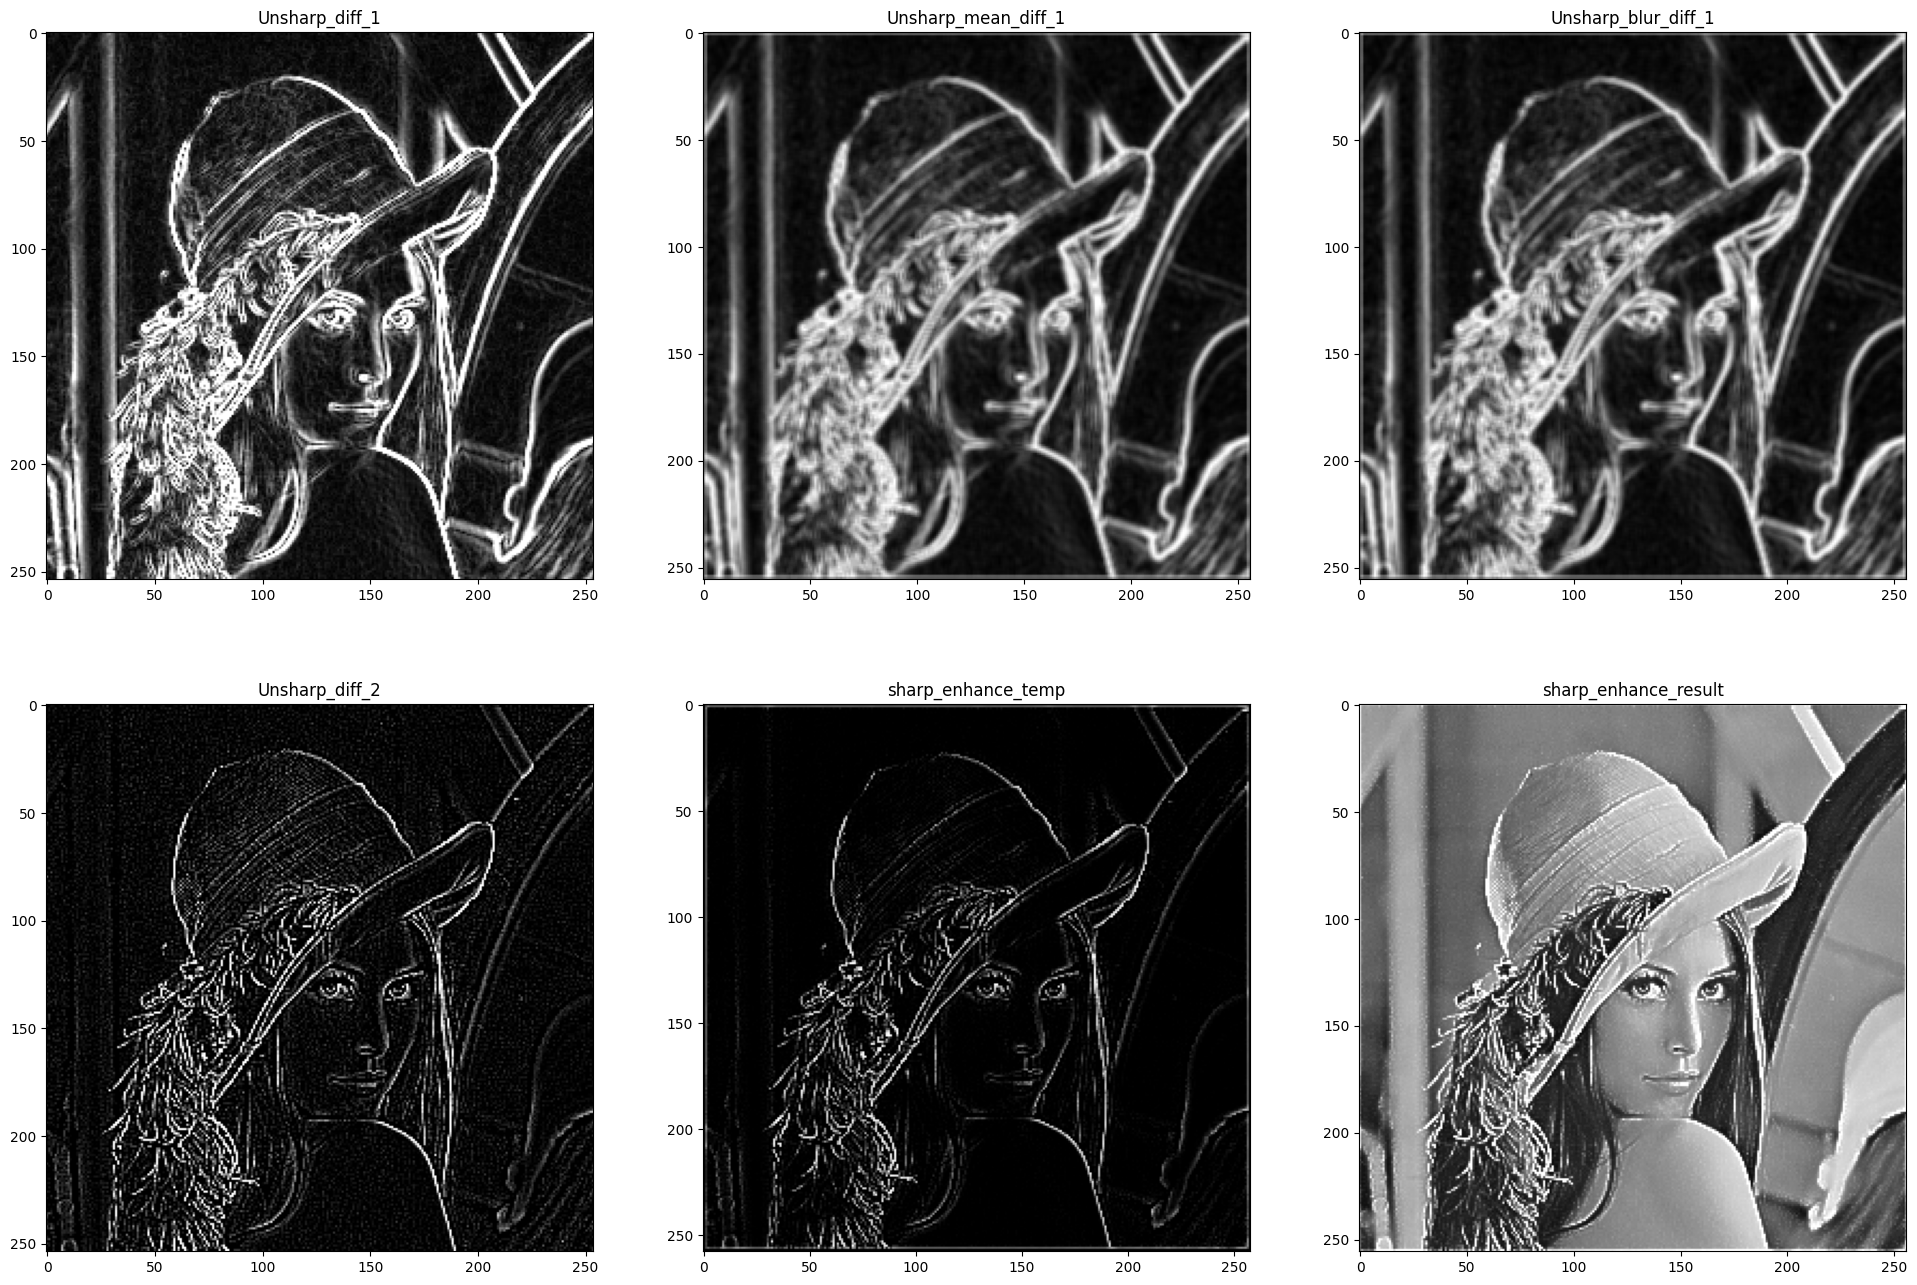

In [6]:
if __name__ == '__main__':

    # STEP 1、讀取彩色圖片轉為灰階圖片並做zero-padding
    img_path="source\Lena_256x256.png"
    # 設 mask 為3*3
    kernel_size=3
    # 來源圖讀取成灰階影像
    img_gray = cv2.imread(img_path ,cv2.IMREAD_GRAYSCALE)
    # zero-padding
    pad=kernel_size//2
    img_padded = np.pad(img_gray, pad) 
    # print(img_padded[0][1],img_padded[1][1],img_padded[2][1])
    # print(img_padded[1][0],img_padded[1][1],img_padded[1][2])
    
    # 各階段的 mask ， sobel 套公式不用卷積
    mean_mask = [1/9, 1/9, 1/9,
                1/9, 1/9, 1/9,
                1/9, 1/9, 1/9]
    laplace_mask = [-1, -1, -1,
                    -1, 8, -1,
                    -1, -1, -1]
    # sobel_x_mask = [-1, 0, 1,
    #                 -2, 0, 2,
    #                 -1, 0, 1]
    # sobel_y_mask = [-1, -2, -1,
    #                 0, 0, 0,
    #                 1, 2, 1]

    # STEP 2、對STEP1 灰階圖片做sobel filter 得一階微分Eage影像
    img_diff1=sobel(img_padded,pad)

    # STEP 3、對STEP2一階微分Edge影像 做 Mean filter得模糊影像 (去雜訊)
    img_mean_diff1=convolution(img_diff1,mean_mask,pad)

    # STEP 4、對STEP3模糊影像 做正規化 得正規化影像 (加速後面運算)
    img_blur_diff1=np.zeros(img_padded.shape,dtype=np.uint8)
    img_blur_diff1=img_mean_diff1/255
    img_blur_diff1=np.clip(img_blur_diff1,0,255) # boundary check 超過邊界拉回在邊界上

    # STEP 5、對STEP1灰階圖片做Laplacian 得二階微分Edge影像
    img_diff2=convolution(img_padded,laplace_mask,pad)

    # STEP6、將 STEP 4 正規化影像 乘以 STEP 5 二階微分Edge影像
    img_enhance_temp=np.zeros(img_padded.shape)
    img_enhance_temp=img_blur_diff1*img_diff2
    img_enhance_temp=np.clip(img_enhance_temp,0,255)# boundary check 超過邊界拉回在邊界上

    # STEP7、STEP6 加上 STEP1原圖得銳化無雜訊結果
    img_enhance=np.zeros(img_padded.shape)
    img_enhance=img_enhance_temp+img_padded
    img_enhance=np.clip(img_enhance,0,255)# boundary check 超過邊界拉回在邊界上


    # 印出圖片 # 刪掉padding的像素[pad:-pad,pad:-pad]
    plt.subplot(111)
    plt.title("Unsharp source")
    plt.imshow(img_gray,cmap='gray')
    plt.show()

    # 刪掉padding的像素[pad:-pad,pad:-pad]
    img_diff1=img_diff1[pad:-pad,pad:-pad]
    img_mean_diff1=img_mean_diff1[pad:-pad,pad:-pad]
    img_blur_diff1=img_blur_diff1[pad:-pad,pad:-pad]
    img_diff2=img_diff2[pad:-pad,pad:-pad]
    img_enhance=img_enhance[pad:-pad,pad:-pad]

    # 印出每階段圖片結果
    plt.figure(figsize=(24,16))
    plt.subplot(231)
    plt.title("Unsharp_diff_1")
    plt.imshow(img_diff1[pad:-pad,pad:-pad],cmap='gray')
    plt.subplot(232)
    plt.title("Unsharp_mean_diff_1")
    plt.imshow(img_mean_diff1,cmap='gray')
    plt.subplot(233)
    plt.title("Unsharp_blur_diff_1")
    plt.imshow(img_blur_diff1,cmap='gray')
    plt.subplot(234)
    plt.title("Unsharp_diff_2")
    plt.imshow(img_diff2[pad:-pad,pad:-pad],cmap='gray')
    plt.subplot(235)
    plt.title("sharp_enhance_temp")
    plt.imshow(img_enhance_temp,cmap='gray')
    plt.subplot(236)
    plt.title("sharp_enhance_result")
    plt.imshow(img_enhance,cmap='gray')
    plt.show()

    # 保存圖片
    cv2.imwrite("result/img_diff1.png", img_diff1)
    cv2.imwrite("result/img_mean_diff1.png", img_mean_diff1)
    cv2.imwrite("result/img_blur_diff1.png", img_blur_diff1)
    cv2.imwrite("result/img_diff2.png", img_diff2)
    cv2.imwrite("result/img_enhance_temp.png", img_enhance_temp)
    cv2.imwrite("result/img_enhance.png", img_enhance)

    